In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy.matlib

<Figure size 432x288 with 0 Axes>

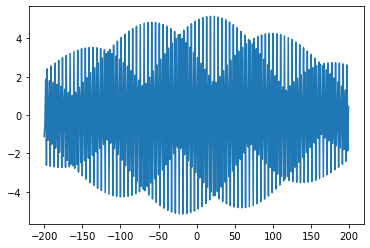

In [2]:
#compute the phi wavelet to approximate the triangular frequency filter

t = np.arange(-10,10,0.1)
def Hanning(t:np.array, s:int)->float :
    #compute the Hannin window
    #variable time is a time vector
    #s is the width of the window
    return np.where(abs(t) <=0.5*s, 0.5+0.5*np.cos(2*m.pi*t/s), 0)

def phi_n(eta_n:float,w_n:float, t:float) -> float :
    #psi_n is the triangle frequency filter, approximated by phi_n
    #t is time
    #triangles centered on eta_n 
    #full width at half maximum (FWHM) w_n
    sigma_n = 2*m.sqrt(2*m.log(2))/w_n
    
    phi_n = np.exp(-2*m.pi*1j*eta_n*t) * (1/m.sqrt(2*m.pi*sigma_n)) * np.exp((-t**2)/2*sigma_n**2)
    #what about the normalisation?
    return phi_n

def compute_filter_bank(N:int,w:int, f_start:int,f_end:int) ->np.array:
    #N is the number of filters
    #w is the width in number of samples
    #fstart is the beginning of the frequencies covered by the filterbank and fends its end
    #duree is the width of the filter (length of the window/sample frequency) in number of samples
    #It seems that w and duree are always the same
    #return filter_bank an array with at each column a filter bank, size(duree,N)
    duree = w
    filter_bank_phi = np.zeros((duree,2*N))
    
    #compute mel-scale:
    f_range = np.arange(f_start,f_end,1)
    mel_range = 2595*np.log10(1+f_range/700)
    #take N equaly spaced frequencies
    idx = np.round(np.linspace(0, len(mel_range) - 1, N)).astype(int)
    eta_vect = mel_range[idx]
    
    #create time vector for hanning and gabor
    #centered on 0 and its length is duree
    t = np.arange(-duree/2,duree/2,1)
    i=0
    for eta_n in eta_vect:
        temp_complex = phi_n(eta_n, w, t)
        filter_bank_phi[:,2*i] = temp_complex.real
        filter_bank_phi[:,2*i+1] = temp_complex.imag
        i=i+1
    return filter_bank_phi
    


# plt.figure()
# fig, ax = plt.subplots()
# print(Hanning(t,2))
# ax.plot(t,Hanning(t,2))
# plt.show()

# plt.figure()
# fig, ax = plt.subplots()
# print(phi_n(1,20,t))
# ax.plot(t,phi_n(1,20,t))
# plt.show()
duree = 400
filter_bank_phi = compute_filter_bank(N = 40,w = 400, f_start = 64,f_end = 8000)
t = np.arange(-duree/2,duree/2,1)
plt.figure()
fig, ax = plt.subplots()
ax.plot(t,filter_bank_phi[:,1])
plt.show()


In [3]:
class ExampleRandomNormal(tf.keras.initializers.Initializer):

    def __init__(self, mean, stddev):
      self.mean = mean
      self.stddev = stddev

    def __call__(self, shape, dtype=None):
      return tf.random.normal(
          shape, mean=self.mean, stddev=self.stddev, dtype=dtype)

    def get_config(self):  # To support serialization
      return {'mean': self.mean, 'stddev': self.stddev}

In [ ]:
#input is a 1d 400 steps long
#filters	Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
#kernel_size	An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.


length = 10002
batch_size = 4
input_shape = (batch_size, length, 1)
x = tf.random.normal(input_shape)
#Initializer = tf.keras.initializers.ExampleRandomNormal()
def init_TDmel(shape, dtype=None):
    #initialize with the TD mel filterbank
    #shape is (width of the filter, 1, number of filters)
    weight =  compute_filter_bank(N = int(shape[2]*0.5),w = shape[0], f_start = 64,f_end = 8000)
    return weight.reshape(shape)

def init_Hanning(shape, dtype=None):
    print(shape)
    t = np.arange(-duree/2,duree/2,1)
    weight = Hanning(t, s=shape[0])
    weight = np.matlib.repmat(weight, 1, shape[2])

    return weight.reshape(shape)

#Initializer = 
y = tf.keras.layers.Conv1D(filters = 80, kernel_size = 400, activation='relu',
                          bias_initializer = tf.keras.initializers.Zeros(), kernel_initializer = init_TDmel)(x)
#compute L2 Norm
a = y[:,:,::2]#even elements (real part)
b = y[:,:,1::2]#uneven elements (imaginary part)
y = np.sqrt(a+b)#norm of elements (only 40 channels now)
#apply haning window separately on each 40 channels (need to repmat hanning and do grouped conv)
y = tf.keras.layers.Conv1D(filters = 40, kernel_size = 400, groups = 40, strides = 160, activation='relu',
                          bias_initializer = tf.keras.initializers.Zeros(), kernel_initializer = init_Hanning)(y)
y = np.abs(y)
y = np.log(1+y)

print(y.shape)

In [ ]:

plt.figure()
fig, ax = plt.subplots()
ax.plot(np.arange(58),y[1,:,6])
plt.show()